## 1. IMPORTS & SETUP

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import os
import sys

print("✓ Librerie importate")
print(f"PyTorch version: {torch.__version__}")
print(f"Device disponibile: {torch.device('cuda' if torch.cuda.is_available() else 'cpu')}")

✓ Librerie importate
PyTorch version: 2.7.1+cu118
Device disponibile: cuda


## 2. DATA LOADING

In [2]:
# Leggi il file Parquet OVEN
Oven = pd.read_parquet("datasets_by_subject/Warmtepomp-Sturing.parquet")
Oven['_time'] = pd.to_datetime(Oven['_time'])
Oven = Oven.sort_values('_time').reset_index(drop=True)
print(f"Oven caricato: {Oven.shape[0]} righe, {Oven.shape[1]} colonne")
Oven.head()

Oven caricato: 35037 righe, 12 colonne


,_time,_measurement,_field,_value,building,device_ID,msr_ID,msr_category,msr_device,msr_extra,msr_spec,msr_subject
0,2024-10-20 02:15:00,Electricity,kW,-0.007910,Household_1_JVR,33a8340b-f03c-4851-9f9f-99b98e2c4cc9,100000029,Power_active,Smappee,L2,Consumption_Production,Warmtepomp - Sturing
1,2024-10-20 02:30:00,Electricity,kW,-0.007956,Household_1_JVR,33a8340b-f03c-4851-9f9f-99b98e2c4cc9,100000029,Power_active,Smappee,L2,Consumption_Production,Warmtepomp - Sturing
2,2024-10-20 02:45:00,Electricity,kW,-0.007950,Household_1_JVR,33a8340b-f03c-4851-9f9f-99b98e2c4cc9,100000029,Power_active,Smappee,L2,Consumption_Production,Warmtepomp - Sturing
3,2024-10-20 03:00:00,Electricity,kW,-0.007968,Household_1_JVR,33a8340b-f03c-4851-9f9f-99b98e2c4cc9,100000029,Power_active,Smappee,L2,Consumption_Production,Warmtepomp - Sturing
4,2024-10-20 03:15:00,Electricity,kW,-0.007880,Household_1_JVR,33a8340b-f03c-4851-9f9f-99b98e2c4cc9,100000029,Power_active,Smappee,L2,Consumption_Production,Warmtepomp - Sturing


In [3]:
# Carica BUILDING (estrae dal dataset principale se necessario)
building_path = "datasets_by_subject/Building.parquet"

if not os.path.exists(building_path):
    print("Estraggo Building dal dataset principale...")
    df_main = pd.read_parquet("influxdb_query_20251020_074134.parquet")
    Building = df_main[df_main['msr_subject'] == 'Building'].copy()
    Building = Building.sort_values('_time').reset_index(drop=True)
    Building.to_parquet(building_path, compression='snappy', engine='fastparquet')
    print(f"✓ Building salvato in {building_path}")
else:
    Building = pd.read_parquet(building_path)
    Building['_time'] = pd.to_datetime(Building['_time'])

print(f"Building caricato: {Building.shape[0]} righe, {Building.shape[1]} colonne")
Building.head()

Building caricato: 140148 righe, 12 colonne


,_time,_measurement,_field,_value,building,device_ID,msr_ID,msr_category,msr_device,msr_extra,msr_spec,msr_subject
index,,,,,,,,,,,,
420440,2024-10-20 02:15:00,Electricity,kW,0.198563,Household_1_JVR,33a8340b-f03c-4851-9f9f-99b98e2c4cc9,100000038,Power_active,Smappee,Total,Consumption,Building
420441,2024-10-20 02:30:00,Electricity,kW,0.228958,Household_1_JVR,33a8340b-f03c-4851-9f9f-99b98e2c4cc9,100000038,Power_active,Smappee,Total,Consumption,Building
420442,2024-10-20 02:45:00,Electricity,kW,0.216411,Household_1_JVR,33a8340b-f03c-4851-9f9f-99b98e2c4cc9,100000038,Power_active,Smappee,Total,Consumption,Building
420443,2024-10-20 03:00:00,Electricity,kW,0.170043,Household_1_JVR,33a8340b-f03c-4851-9f9f-99b98e2c4cc9,100000038,Power_active,Smappee,Total,Consumption,Building
420444,2024-10-20 03:15:00,Electricity,kW,0.180233,Household_1_JVR,33a8340b-f03c-4851-9f9f-99b98e2c4cc9,100000038,Power_active,Smappee,Total,Consumption,Building


## 3. EXPLORATORY DATA ANALYSIS

In [4]:
# Analizza OVEN
time_diff = Oven['_time'].diff()
total_duration = Oven['_time'].max() - Oven['_time'].min()

print("=== OVEN ===")
print(f"Intervallo minimo: {time_diff.min()}")
print(f"Intervallo massimo: {time_diff.max()}")
print(f"Intervallo medio: {time_diff.mean()}")
print(f"Durata totale: {total_duration.days} giorni")
print(f"Righe per giorno: {len(Oven) / total_duration.days:.0f}")

# Calcola sequenze per 1 giorno
rows_for_1_day = int((len(Oven) / total_duration.days) * 1)
print(f"Righe per 1 giorno: {rows_for_1_day}")

=== OVEN ===
Intervallo minimo: 0 days 00:00:00
Intervallo massimo: 0 days 01:15:00
Intervallo medio: 0 days 00:15:00.077063591
Durata totale: 364 giorni
Righe per giorno: 96
Righe per 1 giorno: 96


In [ ]:
# Analizza BUILDING
time_diff_building = Building['_time'].diff()
total_duration_building = Building['_time'].max() - Building['_time'].min()

print("=== BUILDING ===")
print(f"Intervallo minimo: {time_diff_building.min()}")
print(f"Intervallo massimo: {time_diff_building.max()}")
print(f"Intervallo medio: {time_diff_building.mean()}")
print(f"Durata totale: {total_duration_building.days} giorni")
print(f"Righe per giorno: {len(Building) / total_duration_building.days:.0f}")

rows_for_1_day_building = int((len(Building) / total_duration_building.days) * 1)
print(f"Righe per 1 giorno: {rows_for_1_day_building}")

# Configurazione input/output
input_days = 10   # 10 giorni di input
output_days = 1   # 1 giorno di output

print(f"Output: {output_days} giorno = {output_window} righe")

rows_per_day = min(rows_for_1_day, rows_for_1_day_building)print(f"Input: {input_days} giorni = {input_window} righe")

input_window = rows_per_day * input_daysprint(f"\n=== CONFIGURAZIONE ===")

output_window = rows_per_day * output_days

=== BUILDING ===
Intervallo minimo: -365 days +00:15:00
Intervallo massimo: 0 days 01:15:00
Intervallo medio: 0 days 00:03:45.014449114
Durata totale: 364 giorni
Righe per giorno: 385
Righe per 1 giorno: 385

Window size scelto: 96 (sequenza di ~1 giorno)


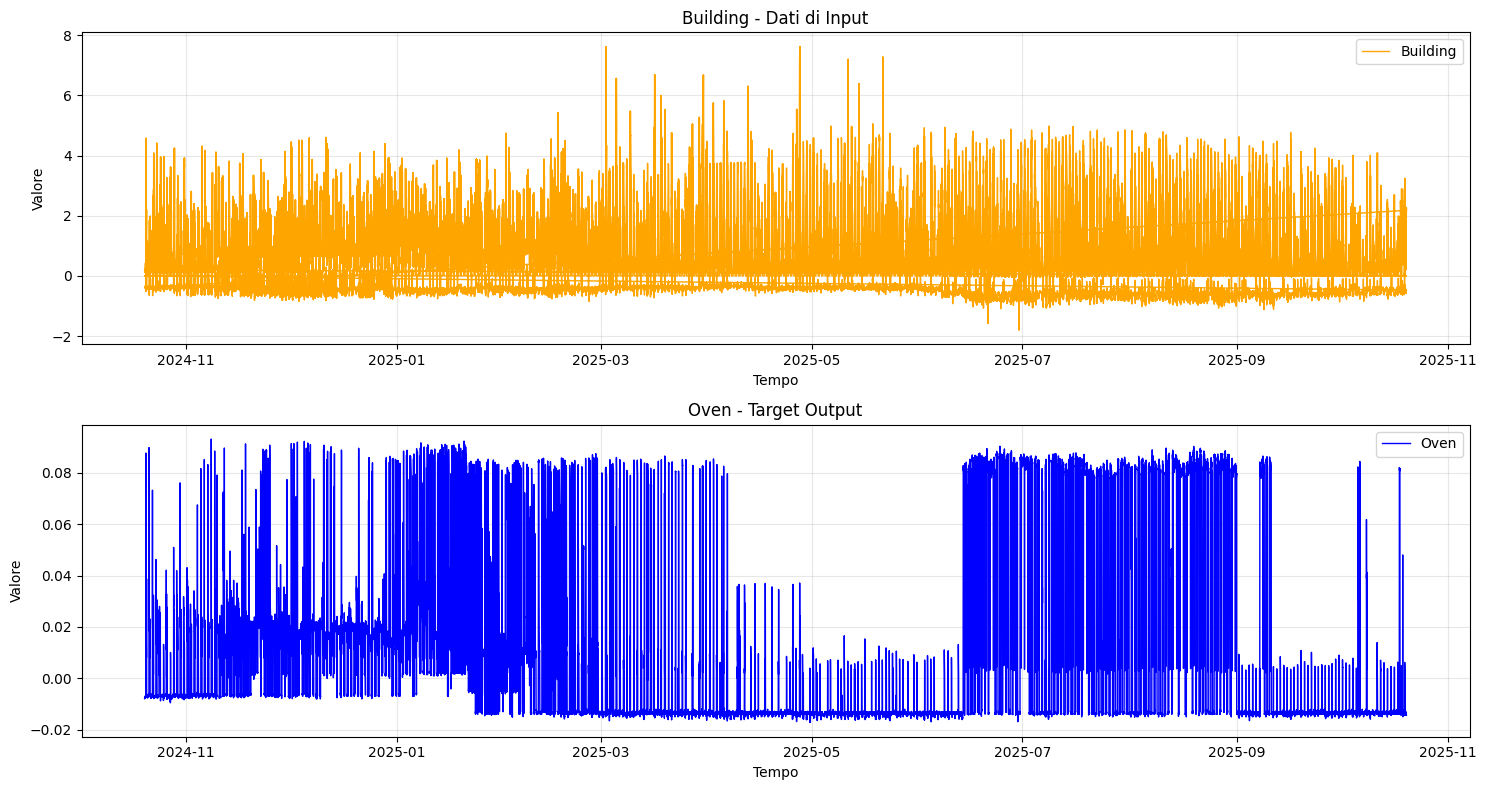

In [6]:
# Visualizza le timeline complete
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

axes[0].plot(Building['_time'], Building['_value'], linewidth=1, color='orange', label='Building')
axes[0].set_title('Building - Dati di Input')
axes[0].set_xlabel('Tempo')
axes[0].set_ylabel('Valore')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

axes[1].plot(Oven['_time'], Oven['_value'], linewidth=1, color='blue', label='Oven')
axes[1].set_title('Oven - Target Output')
axes[1].set_xlabel('Tempo')
axes[1].set_ylabel('Valore')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

## 4. SEQUENCE CREATION

In [ ]:
def create_multi_day_sequences(df_input, df_target, input_len, output_len, step=1):
    """
    Crea sequenze con input e output di lunghezze diverse.
    
    Args:
        df_input: DataFrame con dati di input (Building)
        df_target: DataFrame con dati target (Oven)
        input_len: lunghezza sequenza di input (es. 10 giorni)
        output_len: lunghezza sequenza di output (es. 1 giorno)
        step: passo tra sequenze consecutive
    
    Returns:
        input_sequences: lista di array (input_len, 1)
        target_sequences: lista di array (output_len, 1)
    """
    input_sequences = []
    target_sequences = []
    
    max_idx = min(len(df_input), len(df_target)) - input_len
    
    for i in range(0, max_idx, step):
        # Input: [i : i + input_len]
        input_seq = df_input.iloc[i:i+input_len][['_value']].values
        
        # Target: ultimi output_len punti dell'input window
        # (prediciamo l'ultimo giorno della finestra di input)
        target_start = i + input_len - output_len
        target_seq = df_target.iloc[target_start:target_start+output_len][['_value']].values
        
        input_sequences.append(input_seq)
        target_sequences.append(target_seq)
    

    return input_sequences, target_sequencesprint("✓ Funzione create_multi_day_sequences definita")


✓ Funzione create_lstm_sequences definita


In [8]:
# Crea le sequenze con input più lungo e output di 1 giorno
print(f"Creazione sequenze: {input_days} giorni input → {output_days} giorno output...")

X_input, Y_target = create_multi_day_sequences(
    Building, Oven, 
    input_len=input_window, 
    output_len=output_window,
    step=rows_per_day  # step di 1 giorno
)

print(f"\n✓ Sequenze create: {len(X_input)}")
print(f"✓ Input shape: {X_input[0].shape} ({input_days} giorni)")
print(f"✓ Target shape: {Y_target[0].shape} ({output_days} giorno)")

Creazione sequenze con window_size=96...
Sequenze Building create: 140053
Sequenze Oven create: 34942

✓ Sequenze Building: 34942
✓ Sequenze Oven: 34942
✓ Dimensione sequenza: (96, 12)


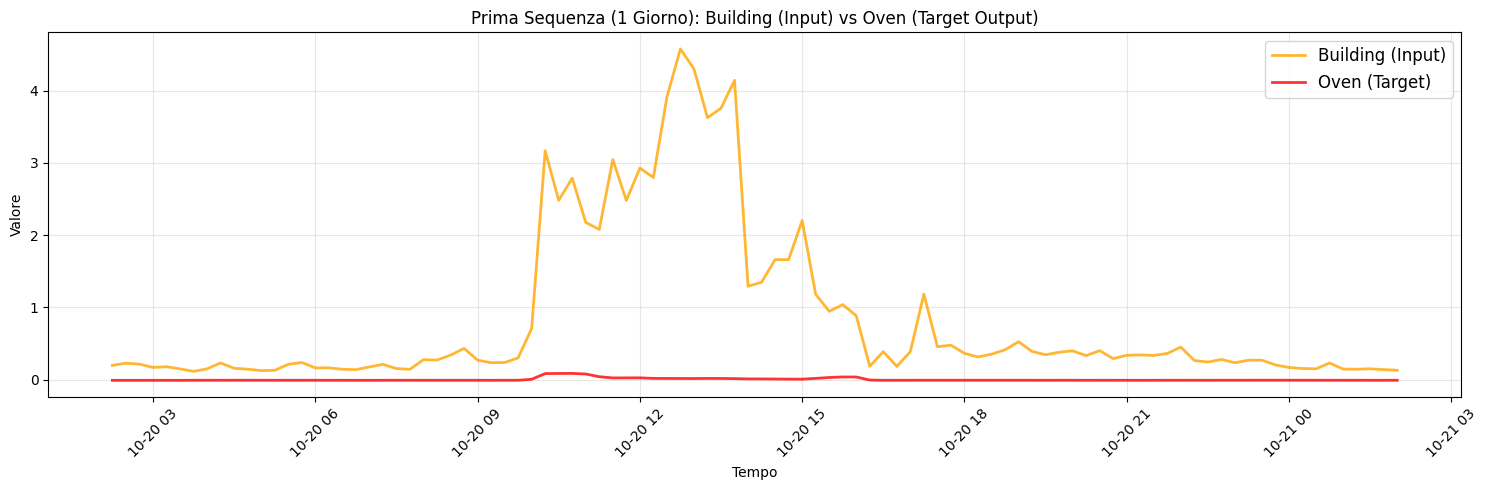

In [ ]:
# Visualizza esempio: 10 giorni input → 1 giorno output
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Input (10 giorni)
axes[0].plot(range(input_window), X_input[0].flatten(), linewidth=1.5, color='orange', label=f'Building Input ({input_days} giorni)')
axes[0].axvline(x=input_window - output_window, color='red', linestyle='--', linewidth=2, label='Inizio finestra target')
axes[0].set_title(f'Input: {input_days} giorni di Building')
axes[0].set_xlabel('Time steps')
axes[0].set_ylabel('Valore')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Output (1 giorno)
axes[1].plot(range(output_window), Y_target[0].flatten(), linewidth=2, color='red', label=f'Oven Target ({output_days} giorno)')
axes[1].set_title(f'Output: {output_days} giorno di Oven (da predire)')
axes[1].set_xlabel('Time steps')
axes[1].set_ylabel('Valore')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nIl modello userà {input_days} giorni di Building per predire {output_days} giorno di Oven")

## 5. MODEL DEFINITION

In [ ]:
class CNNEncoder(nn.Module):
    """Encoder CNN per input lungo (10 giorni)"""
    def __init__(self, input_len, hidden_channels=64, num_layers=4):
        super(CNNEncoder, self).__init__()
        
        layers = []
        in_channels = 1
        
        for i in range(num_layers):
            # Usa kernel più grandi per catturare pattern multi-giorno
            kernel_size = 7 if i < 2 else 3
            padding = kernel_size // 2
            layers.extend([
                nn.Conv1d(in_channels, hidden_channels, kernel_size=kernel_size, padding=padding),
                nn.BatchNorm1d(hidden_channels),
                nn.ReLU(),
                nn.Dropout(0.1)
            ])
            in_channels = hidden_channels
        
        self.conv_layers = nn.Sequential(*layers)
        self.input_len = input_len
        
    def forward(self, x):
        # x: (batch, input_len, 1) -> (batch, 1, input_len)
        x = x.transpose(1, 2)
        features = self.conv_layers(x)
        # features: (batch, hidden_channels, input_len)
        return features


class CNNDecoder(nn.Module):
    """Decoder CNN che riduce da input_len a output_len"""
    def __init__(self, input_len, output_len, hidden_channels=64, num_layers=4):
        super(CNNDecoder, self).__init__()
        
        self.input_len = input_len
        self.output_len = output_len
        
        # Adaptive pooling per ridurre la dimensione
        self.adaptive_pool = nn.AdaptiveAvgPool1d(output_len)
        
        layers = []
        for i in range(num_layers):
            layers.extend([
                nn.Conv1d(hidden_channels, hidden_channels, kernel_size=3, padding=1),
                nn.BatchNorm1d(hidden_channels),
                nn.ReLU(),
                nn.Dropout(0.1)
            ])
        
        self.conv_layers = nn.Sequential(*layers)
        self.output_conv = nn.Conv1d(hidden_channels, 1, kernel_size=1)
        
    def forward(self, encoder_features):
        # encoder_features: (batch, hidden_channels, input_len)
        
        # Riduci da input_len a output_len
        x = self.adaptive_pool(encoder_features)
        # x: (batch, hidden_channels, output_len)
        
        x = self.conv_layers(x)
        output = self.output_conv(x)
        # output: (batch, 1, output_len) -> (batch, output_len, 1)
        return output.transpose(1, 2)


class CNNSeq2Day(nn.Module):
    """
    Modello CNN: Input lungo (N giorni) → Output corto (1 giorno)
    """
    def __init__(self, input_len, output_len, hidden_channels=64, num_layers=4):
        super(CNNSeq2Day, self).__init__()
        self.encoder = CNNEncoder(input_len, hidden_channels, num_layers)
        self.decoder = CNNDecoder(input_len, output_len, hidden_channels, num_layers)
        self.input_len = input_len
        self.output_len = output_len
        
    def forward(self, source):
        encoder_features = self.encoder(source)
        output = self.decoder(encoder_features)
        return output

print("✓ Modello CNN Seq2Day definito")
print(f"  - Input: {input_days} giorni ({input_window} steps)")
print(f"  - Output: {output_days} giorno ({output_window} steps)")

✓ Modello CNN 2D Seq2Seq definito
  - Usa Conv2D con kernel (1, 3)
  - Funziona con le sequenze esistenti!


## 6. DATA PREPARATION FOR TRAINING

In [ ]:
class EnergyDataset(Dataset):
    def __init__(self, input_sequences, target_sequences):
        # Converte liste di array numpy in tensori
        self.input_sequences = [torch.FloatTensor(seq) for seq in input_sequences]
        self.target_sequences = [torch.FloatTensor(seq) for seq in target_sequences]
    
    def __len__(self):
        return len(self.input_sequences)
    
    def __getitem__(self, idx):
        return self.input_sequences[idx], self.target_sequences[idx]

print("✓ EnergyDataset definito")

✓ EnergyDataset definito


## 7. TRAINING

In [ ]:
# ===== CONFIGURAZIONE CNN Seq2Day =====
# Input: 10 giorni → Output: 1 giorno

batch_size = 128          # Batch size
hidden_channels = 128     # Canali CNN
num_layers = 5            # Layer CNN
num_epochs = 100          # Epoche
learning_rate = 0.001     # Learning rate

# Crea dataset e dataloader
train_dataset = EnergyDataset(X_input, Y_target)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

num_sequences = len(X_input)
num_batches = len(train_loader)

print("=" * 60)
print("CONFIGURAZIONE CNN Seq2Day")
print("=" * 60)
print(f"Input: {input_days} giorni ({input_window} steps)")
print(f"Output: {output_days} giorno ({output_window} steps)")
print(f"Sequenze: {num_sequences:,}")
print(f"Batch size: {batch_size} | Batches/epoca: {num_batches}")
print(f"Modello: CNN con {num_layers} layer, {hidden_channels} canali")
print(f"Device: {'GPU 🚀' if torch.cuda.is_available() else 'CPU'}")
print("=" * 60)

# Setup device e modello
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNNSeq2Day(input_window, output_window, hidden_channels, num_layers).to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"\n✓ Modello CNN 2D: {total_params:,} parametri")

# Loss function
class StrictZeroWeightedMSELoss(nn.Module):
    def __init__(self, zero_threshold=0.01, penalty_factor=50.0):
        super(StrictZeroWeightedMSELoss, self).__init__()
        self.zero_threshold = zero_threshold
        self.penalty_factor = penalty_factor
    
    def forward(self, predictions, targets):
        squared_error = (predictions - targets) ** 2
        
        should_be_zero = torch.abs(targets) < self.zero_threshold
        pred_not_zero = torch.abs(predictions) >= self.zero_threshold
        
        weights = torch.ones_like(targets)
        penalty_mask = should_be_zero & pred_not_zero
        weights[penalty_mask] = self.penalty_factor
        
        normal_mask = ~should_be_zero
        if normal_mask.sum() > 0:
            normal_targets = torch.abs(targets[normal_mask])
            normal_weights = normal_targets / (normal_targets.max() + 1e-8)
            normal_weights = 1.0 + normal_weights * 3.0
            weights[normal_mask] = normal_weights
        
        return (squared_error * weights).mean()

criterion = StrictZeroWeightedMSELoss(zero_threshold=0.01, penalty_factor=50.0)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print("✓ Loss e optimizer configurati")

CONFIGURAZIONE CNN 2D
Sequenze: 11,648 (step=3)
Batch size: 256 | Batches/epoca: 46
Modello: CNN 2D con 5 layer, 128 canali
Device: GPU 🚀

✓ Modello CNN 2D: 446,721 parametri
✓ Loss e optimizer configurati


In [ ]:
import time

def train_epoch(model, iterator, optimizer, criterion, device):
    model.train()
    epoch_loss = 0
    start_time = time.time()
    
    for input_seq, target_seq in iterator:
        input_seq = input_seq.to(device)
        target_seq = target_seq.to(device)
        
        output = model(input_seq)  # CNN 2D non usa teacher forcing
        loss = criterion(output, target_seq)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        epoch_loss += loss.item()
    
    elapsed = time.time() - start_time
    return epoch_loss / len(iterator), elapsed

# Training
train_losses = []
print(f"\n🚀 Inizio training CNN Seq2Day ({num_epochs} epoche)...")
print(f"   Input: {input_days} giorni → Output: {output_days} giorno\n")

for epoch in range(num_epochs):
    train_loss, elapsed = train_epoch(model, train_loader, optimizer, criterion, device)
    train_losses.append(train_loss)
    
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{num_epochs} | Loss: {train_loss:.6f} | Time: {elapsed:.1f}s")

print("\n✓ Training completato!")


🚀 Inizio training CNN 2D (100 epoche)...

Epoch   1/100 | Loss: 0.252689 | Time: 7.8s
Epoch  10/100 | Loss: 0.004270 | Time: 4.1s
Epoch  20/100 | Loss: 0.003471 | Time: 4.2s
Epoch  30/100 | Loss: 0.003111 | Time: 4.2s
Epoch  40/100 | Loss: 0.002808 | Time: 4.2s
Epoch  50/100 | Loss: 0.002442 | Time: 4.1s
Epoch  60/100 | Loss: 0.001973 | Time: 4.2s
Epoch  70/100 | Loss: 0.001555 | Time: 4.2s
Epoch  80/100 | Loss: 0.001220 | Time: 4.5s
Epoch  90/100 | Loss: 0.001053 | Time: 5.7s
Epoch 100/100 | Loss: 0.000917 | Time: 5.7s

✓ Training completato!


## 8. RESULTS & VISUALIZATION

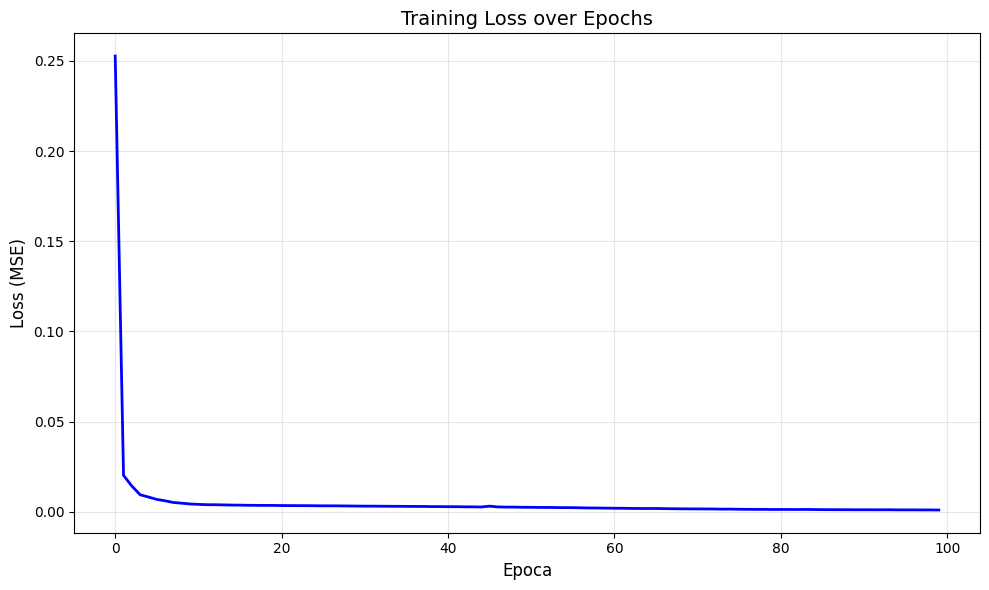

Loss iniziale: 0.252689
Loss finale: 0.000917


In [14]:
# Plot della loss durante il training
plt.figure(figsize=(10, 6))
plt.plot(train_losses, linewidth=2, color='blue')
plt.xlabel('Epoca', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training Loss over Epochs', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Loss iniziale: {train_losses[0]:.6f}")
print(f"Loss finale: {train_losses[-1]:.6f}")

In [ ]:
# Salva il modello
model_path = "seq2day_cnn_energy_model.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'hyperparameters': {
        'hidden_channels': hidden_channels,
        'num_layers': num_layers,
        'input_window': input_window,
        'output_window': output_window,
        'input_days': input_days,
        'output_days': output_days
    },

    'train_losses': train_lossesprint(f"✓ Modello CNN Seq2Day salvato: {model_path}")
}, model_path)

✓ Modello CNN 2D salvato: seq2seq_cnn2d_energy_model.pth


## 9. INFERENCE & EVALUATION

In [ ]:
# Test su una sequenza
test_idx = 5  # Scegli un indice per il test

model.eval()
with torch.no_grad():
    test_input = torch.FloatTensor(X_input[test_idx]).unsqueeze(0).to(device)
    test_target = torch.FloatTensor(Y_target[test_idx]).unsqueeze(0).to(device)
    
    predictions = model(test_input)
    predictions = predictions.cpu().numpy().squeeze()
    actual = test_target.cpu().numpy().squeeze()

from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(actual, predictions)
mae = mean_absolute_error(actual, predictions)


print(f"Test su sequenza {test_idx}:")print(f"Test MAE: {mae:.6f}")

print(f"  Input: {input_days} giorni di Building")print(f"\nTest MSE: {mse:.6f}")
print(f"  Output: {output_days} giorno di Oven predetto")

Test MSE: 0.000086
Test MAE: 0.005276


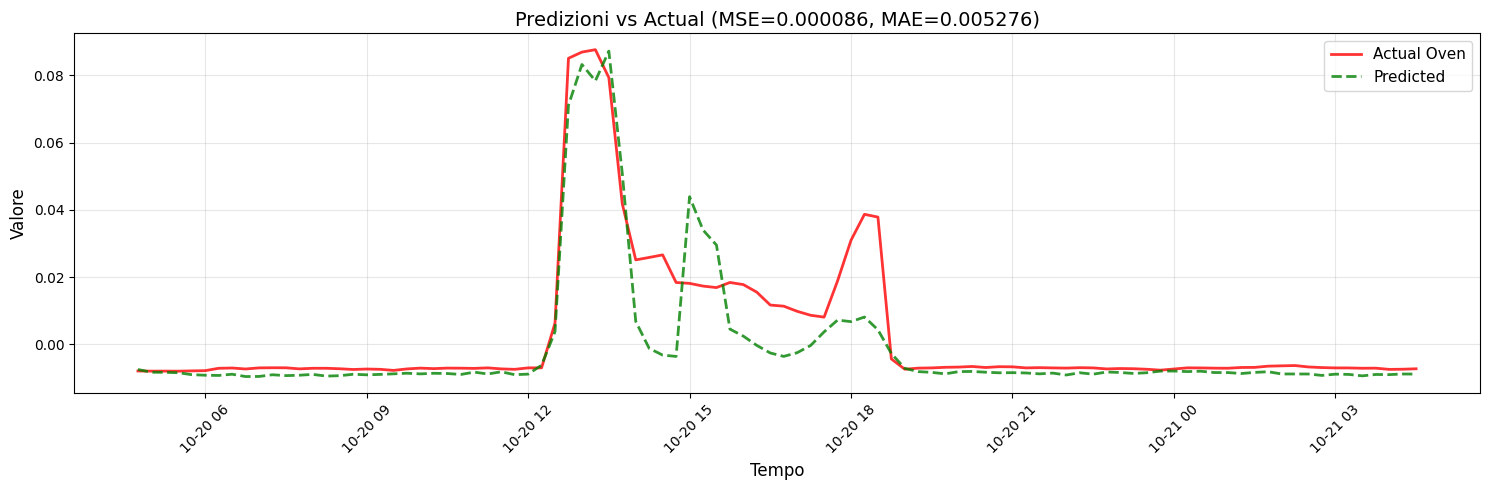

In [ ]:
# Visualizza predizioni vs actual (1 giorno predetto)
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# Input usato (10 giorni)
axes[0].plot(range(input_window), X_input[test_idx].flatten(), linewidth=1.5, color='orange', label=f'Building Input ({input_days} giorni)')
axes[0].axvline(x=input_window - output_window, color='red', linestyle='--', linewidth=2, alpha=0.5)
axes[0].set_title(f'Input: {input_days} giorni di Building')
axes[0].set_xlabel('Time steps')
axes[0].set_ylabel('Valore')
axes[0].legend()
axes[0].grid(True, alpha=0.3)


# Output predetto vs actual (1 giorno)plt.show()

axes[1].plot(range(output_window), actual, linewidth=2, label='Actual Oven', color='red', alpha=0.8)plt.tight_layout()

axes[1].plot(range(output_window), predictions, linewidth=2, label='Predicted', color='green', linestyle='--', alpha=0.8)

axes[1].set_title(f'Output: {output_days} giorno - Predizioni vs Actual (MSE={mse:.6f})')axes[1].grid(True, alpha=0.3)

axes[1].set_xlabel('Time steps')axes[1].legend()
axes[1].set_ylabel('Valore')